# Trading Challenge: SMA Crossover Strategy
## Objective: Implement a complete trading system with performance analysis

### Challenge Requirements:
- **Instrument**: EUR/USD (high liquidity, beginner-friendly)
- **Timeframe**: 15 minutes (balanced data points, reduced noise)
- **Strategy**: SMA crossover with last 100 candles
- **Execution**: Market orders on signals
- **Risk Management**: Stop-loss/take-profit
- **Analysis**: Win rate, P/L, drawdown, Sharpe ratio

In [2]:
# Setup and imports
import pandas as pd
from ib_async import *
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt  # pyright: ignore[reportMissingImports]
import warnings
warnings.filterwarnings('ignore')

util.startLoop()
ib = IB()
ib.connect()

Matplotlib is building the font cache; this may take a moment.


<IB connected to 127.0.0.1:7497 clientId=1>

In [3]:
# 1. Select Instrument - EUR/USD
contract = Forex("EURUSD")
ib.qualifyContracts(contract)
print(f"Trading instrument: {contract}")
contract

Trading instrument: Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')


Forex('EURUSD', conId=12087792, exchange='IDEALPRO', localSymbol='EUR.USD', tradingClass='EUR.USD')

In [4]:
# 2. Define timeframe and fetch last 100+ candles for SMA calculation
def get_historical_data(contract, bars_needed=120):
    """Fetch 15-min historical data for SMA calculation"""
    data = ib.reqHistoricalData(
        contract, 
        "", 
        barSizeSetting="15 mins", 
        durationStr="2 D",  # 2 days to ensure we get enough bars
        whatToShow="MIDPOINT", 
        useRTH=False,  # Include after-hours for Forex
        formatDate=2
    )
    df = util.df(data)
    return df.tail(bars_needed)  # Keep only last 120 bars

# Initial data fetch
df = get_historical_data(contract)
print(f"Fetched {len(df)} bars of 15-minute EUR/USD data")
print(f"Date range: {df.date.min()} to {df.date.max()}")
df.tail()

Fetched 120 bars of 15-minute EUR/USD data
Date range: 2025-11-25 14:30:00+00:00 to 2025-11-26 20:30:00+00:00


,date,open,high,low,close,volume,average,barCount
180,2025-11-26 19:30:00+00:00,1.159225,1.159615,1.159225,1.159580,-1.0,-1.0,-1
181,2025-11-26 19:45:00+00:00,1.159580,1.159630,1.159265,1.159370,-1.0,-1.0,-1
182,2025-11-26 20:00:00+00:00,1.159370,1.159580,1.159255,1.159490,-1.0,-1.0,-1
183,2025-11-26 20:15:00+00:00,1.159490,1.159740,1.159460,1.159615,-1.0,-1.0,-1
184,2025-11-26 20:30:00+00:00,1.159615,1.159630,1.159490,1.159570,-1.0,-1.0,-1


Buy signals: 4
Sell signals: 3


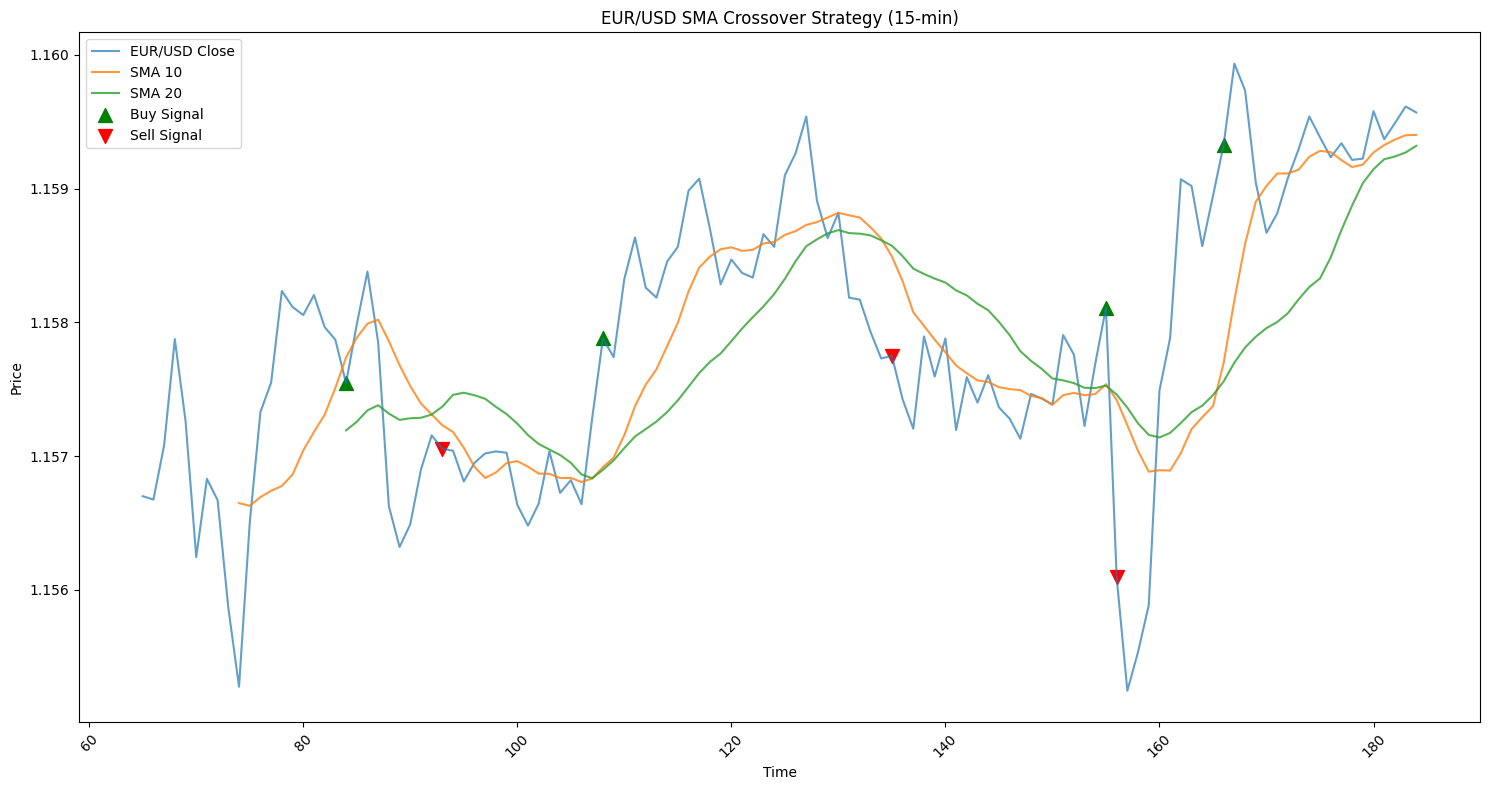

In [5]:
# 3. Implement SMA calculation and crossover logic
def calculate_sma_signals(df, short_period=10, long_period=20):
    """Calculate SMA crossover signals"""
    df = df.copy()
    
    # Calculate SMAs
    df['SMA_short'] = df['close'].rolling(window=short_period).mean()
    df['SMA_long'] = df['close'].rolling(window=long_period).mean()
    
    # Generate signals
    df['signal'] = 0
    df['signal'][short_period:] = np.where(
        df['SMA_short'][short_period:] > df['SMA_long'][short_period:], 1, -1
    )
    
    # Detect crossovers
    df['position'] = df['signal'].diff()
    df['buy_signal'] = (df['position'] == 2)  # From -1 to 1
    df['sell_signal'] = (df['position'] == -2)  # From 1 to -1
    
    return df

# Calculate initial signals
df_signals = calculate_sma_signals(df)
print(f"Buy signals: {df_signals['buy_signal'].sum()}")
print(f"Sell signals: {df_signals['sell_signal'].sum()}")

# Plot the strategy
plt.figure(figsize=(15, 8))
plt.plot(df_signals.index, df_signals['close'], label='EUR/USD Close', alpha=0.7)
plt.plot(df_signals.index, df_signals['SMA_short'], label='SMA 10', alpha=0.8)
plt.plot(df_signals.index, df_signals['SMA_long'], label='SMA 20', alpha=0.8)

# Mark buy/sell signals
buy_points = df_signals[df_signals['buy_signal']]
sell_points = df_signals[df_signals['sell_signal']]
plt.scatter(buy_points.index, buy_points['close'], color='green', marker='^', s=100, label='Buy Signal')
plt.scatter(sell_points.index, sell_points['close'], color='red', marker='v', s=100, label='Sell Signal')

plt.legend()
plt.title('EUR/USD SMA Crossover Strategy (15-min)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# 4. Trading System Configuration
class TradingSystem:
    def __init__(self, ib, contract, position_size=1000, stop_loss_pips=20, take_profit_pips=40):
        self.ib = ib
        self.contract = contract
        self.position_size = position_size  # Base currency units
        self.stop_loss_pips = stop_loss_pips
        self.take_profit_pips = take_profit_pips
        self.pip_value = 0.0001  # For EUR/USD
        
        # Trade tracking
        self.trades = []
        self.current_position = None
        self.account_balance = 10000  # Starting balance
        self.balance_history = [self.account_balance]
        
    def get_current_price(self):
        """Get current market price"""
        ticker = self.ib.reqMktData(self.contract, '', False, False)
        self.ib.sleep(1)  # Wait for data
        price = (ticker.bid + ticker.ask) / 2 if ticker.bid and ticker.ask else ticker.last
        self.ib.cancelMktData(self.contract)
        return price
    
    def place_market_order(self, action, quantity):
        """Place a market order"""
        order = MarketOrder(action, quantity)
        trade = self.ib.placeOrder(self.contract, order)
        self.ib.sleep(2)  # Wait for fill
        return trade
    
    def calculate_stop_take_levels(self, entry_price, action):
        """Calculate stop loss and take profit levels"""
        if action == 'BUY':
            stop_loss = entry_price - (self.stop_loss_pips * self.pip_value)
            take_profit = entry_price + (self.take_profit_pips * self.pip_value)
        else:  # SELL
            stop_loss = entry_price + (self.stop_loss_pips * self.pip_value)
            take_profit = entry_price - (self.take_profit_pips * self.pip_value)
        
        return stop_loss, take_profit
    
    def open_position(self, signal_type):
        """Open a new position based on signal"""
        if self.current_position is not None:
            return  # Already in position
        
        action = 'BUY' if signal_type == 'buy' else 'SELL'
        entry_price = self.get_current_price()
        
        if entry_price is None:
            return
        
        stop_loss, take_profit = self.calculate_stop_take_levels(entry_price, action)
        
        # Simulate order execution (in real trading, you'd place actual orders)
        self.current_position = {
            'action': action,
            'entry_price': entry_price,
            'quantity': self.position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'entry_time': datetime.now()
        }
        
        print(f"Opened {action} position at {entry_price:.5f}")
        print(f"Stop Loss: {stop_loss:.5f}, Take Profit: {take_profit:.5f}")
    
    def check_exit_conditions(self, current_price):
        """Check if position should be closed"""
        if self.current_position is None:
            return False
        
        pos = self.current_position
        
        if pos['action'] == 'BUY':
            hit_stop = current_price <= pos['stop_loss']
            hit_target = current_price >= pos['take_profit']
        else:  # SELL
            hit_stop = current_price >= pos['stop_loss']
            hit_target = current_price <= pos['take_profit']
        
        return hit_stop or hit_target
    
    def close_position(self, exit_price, exit_reason):
        """Close current position and record trade"""
        if self.current_position is None:
            return
        
        pos = self.current_position
        
        # Calculate P&L
        if pos['action'] == 'BUY':
            pnl_pips = (exit_price - pos['entry_price']) / self.pip_value
        else:  # SELL
            pnl_pips = (pos['entry_price'] - exit_price) / self.pip_value
        
        pnl_usd = pnl_pips * self.pip_value * pos['quantity']
        
        # Record trade
        trade_record = {
            'entry_time': pos['entry_time'],
            'exit_time': datetime.now(),
            'action': pos['action'],
            'entry_price': pos['entry_price'],
            'exit_price': exit_price,
            'quantity': pos['quantity'],
            'pnl_pips': pnl_pips,
            'pnl_usd': pnl_usd,
            'exit_reason': exit_reason
        }
        
        self.trades.append(trade_record)
        self.account_balance += pnl_usd
        self.balance_history.append(self.account_balance)
        
        print(f"Closed {pos['action']} position at {exit_price:.5f}")
        print(f"P&L: {pnl_pips:.1f} pips (${pnl_usd:.2f}) - {exit_reason}")
        
        self.current_position = None

# Initialize trading system
trading_system = TradingSystem(ib, contract)
print("Trading system initialized")
print(f"Position size: {trading_system.position_size} units")
print(f"Stop loss: {trading_system.stop_loss_pips} pips")
print(f"Take profit: {trading_system.take_profit_pips} pips")

Trading system initialized
Position size: 1000 units
Stop loss: 20 pips
Take profit: 40 pips


In [7]:
# 5. Simulate Trading (Backtesting on Historical Data)
def backtest_strategy(df_signals, trading_system):
    """Backtest the strategy on historical data"""
    trades_executed = 0
    
    for idx, row in df_signals.iterrows():
        current_price = row['close']
        
        # Check for exit conditions first
        if trading_system.check_exit_conditions(current_price):
            pos = trading_system.current_position
            if pos['action'] == 'BUY':
                if current_price <= pos['stop_loss']:
                    trading_system.close_position(current_price, 'Stop Loss')
                else:
                    trading_system.close_position(current_price, 'Take Profit')
            else:  # SELL
                if current_price >= pos['stop_loss']:
                    trading_system.close_position(current_price, 'Stop Loss')
                else:
                    trading_system.close_position(current_price, 'Take Profit')
        
        # Check for new signals
        if row['buy_signal'] and trading_system.current_position is None:
            trading_system.current_position = {
                'action': 'BUY',
                'entry_price': current_price,
                'quantity': trading_system.position_size,
                'stop_loss': current_price - (trading_system.stop_loss_pips * trading_system.pip_value),
                'take_profit': current_price + (trading_system.take_profit_pips * trading_system.pip_value),
                'entry_time': row['date']
            }
            trades_executed += 1
            
        elif row['sell_signal'] and trading_system.current_position is None:
            trading_system.current_position = {
                'action': 'SELL',
                'entry_price': current_price,
                'quantity': trading_system.position_size,
                'stop_loss': current_price + (trading_system.stop_loss_pips * trading_system.pip_value),
                'take_profit': current_price - (trading_system.take_profit_pips * trading_system.pip_value),
                'entry_time': row['date']
            }
            trades_executed += 1
    
    # Close any remaining position
    if trading_system.current_position is not None:
        trading_system.close_position(df_signals.iloc[-1]['close'], 'End of Data')
    
    print(f"Backtest completed. Trades executed: {trades_executed}")
    print(f"Trades closed: {len(trading_system.trades)}")
    
    return trading_system.trades

# Run backtest
trades = backtest_strategy(df_signals, trading_system)
trades_df = pd.DataFrame(trades)

if len(trades_df) > 0:
    print("\nFirst 5 trades:")
    print(trades_df.head())
else:
    print("No trades were completed in the backtest period.")

Closed BUY position at 1.15525
P&L: -23.0 pips ($-2.30) - Stop Loss
Closed BUY position at 1.15957
P&L: 2.4 pips ($0.24) - End of Data
Backtest completed. Trades executed: 2
Trades closed: 2

First 5 trades:
                 entry_time                  exit_time action  entry_price  \
0 2025-11-25 19:15:00+00:00 2025-11-26 20:39:29.356029    BUY     1.157545   
1 2025-11-26 16:00:00+00:00 2025-11-26 20:39:29.357273    BUY     1.159330   

   exit_price  quantity  pnl_pips  pnl_usd  exit_reason  
0    1.155245      1000     -23.0    -2.30    Stop Loss  
1    1.159570      1000       2.4     0.24  End of Data  


In [8]:
# 6. Performance Analysis
def analyze_performance(trades_df, trading_system):
    """Analyze trading performance and calculate key metrics"""
    if len(trades_df) == 0:
        print("No trades to analyze.")
        return
    
    # Basic metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl_usd'] > 0])
    losing_trades = len(trades_df[trades_df['pnl_usd'] < 0])
    
    # Win rate
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_usd'].sum()
    avg_trade_pnl = trades_df['pnl_usd'].mean()
    avg_winner = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].mean() if winning_trades > 0 else 0
    avg_loser = trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].mean() if losing_trades > 0 else 0
    
    # Calculate maximum drawdown
    balance_series = pd.Series(trading_system.balance_history)
    cumulative_max = balance_series.expanding().max()
    drawdown = (balance_series - cumulative_max) / cumulative_max * 100
    max_drawdown = drawdown.min()
    
    # Calculate Sharpe ratio (simplified)
    if len(trades_df) > 1:
        returns = trades_df['pnl_usd'] / 10000  # Assuming $10k account
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    else:
        sharpe_ratio = 0
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl_usd'] > 0]['pnl_usd'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_usd'] < 0]['pnl_usd'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    print("=" * 50)
    print("PERFORMANCE ANALYSIS RESULTS")
    print("=" * 50)
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.1f}%")
    print()
    print("P&L METRICS:")
    print(f"Total P&L: ${total_pnl:.2f}")
    print(f"Average Trade P&L: ${avg_trade_pnl:.2f}")
    print(f"Average Winner: ${avg_winner:.2f}")
    print(f"Average Loser: ${avg_loser:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print()
    print("RISK METRICS:")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Final Account Balance: ${trading_system.account_balance:.2f}")
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'total_pnl': total_pnl,
        'avg_trade_pnl': avg_trade_pnl,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'profit_factor': profit_factor
    }

# Analyze performance
performance_metrics = analyze_performance(trades_df, trading_system)

PERFORMANCE ANALYSIS RESULTS
Total Trades: 2
Winning Trades: 1
Losing Trades: 1
Win Rate: 50.0%

P&L METRICS:
Total P&L: $-2.06
Average Trade P&L: $-1.03
Average Winner: $0.24
Average Loser: $-2.30
Profit Factor: 0.10

RISK METRICS:
Maximum Drawdown: -0.02%
Sharpe Ratio: -9.10
Final Account Balance: $9997.94


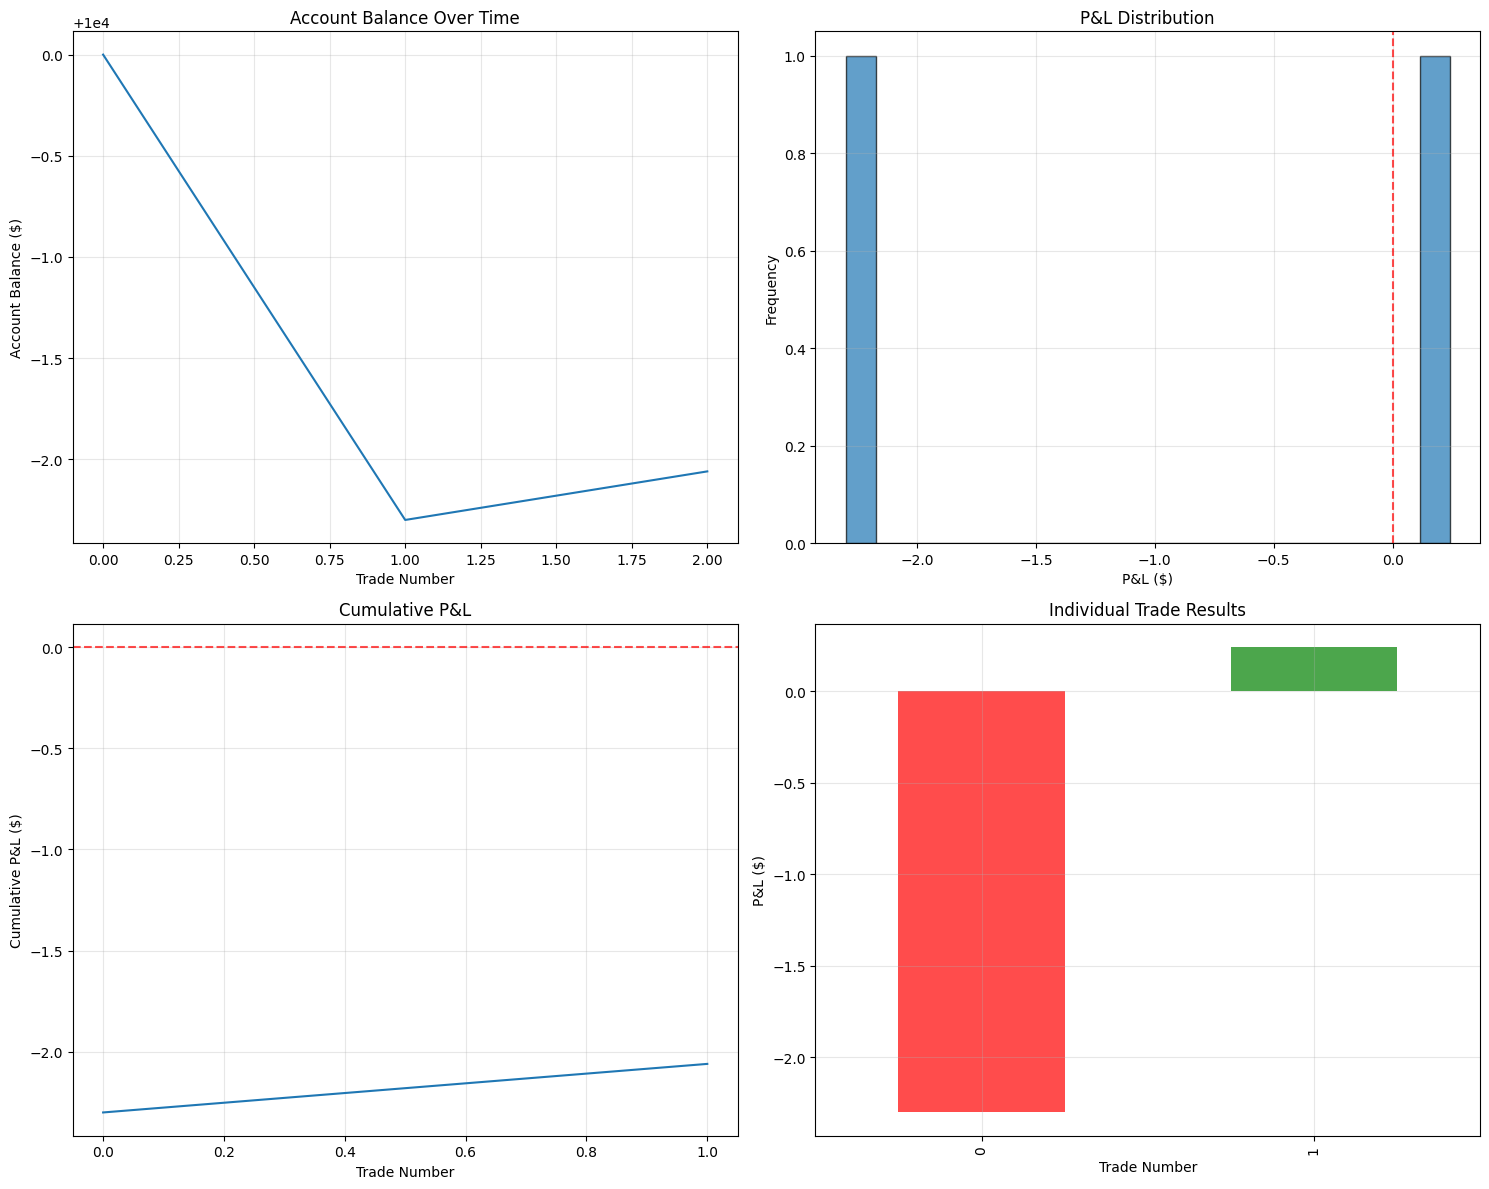


DETAILED TRADE STATISTICS:
                 entry_time action  entry_price  exit_price  pnl_pips  pnl_usd  exit_reason
0 2025-11-25 19:15:00+00:00    BUY     1.157545    1.155245     -23.0    -2.30    Stop Loss
1 2025-11-26 16:00:00+00:00    BUY     1.159330    1.159570       2.4     0.24  End of Data


In [9]:
# 7. Visualization of Results
if len(trades_df) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Equity curve
    ax1.plot(trading_system.balance_history)
    ax1.set_title('Account Balance Over Time')
    ax1.set_xlabel('Trade Number')
    ax1.set_ylabel('Account Balance ($)')
    ax1.grid(True, alpha=0.3)
    
    # 2. P&L distribution
    ax2.hist(trades_df['pnl_usd'], bins=20, alpha=0.7, edgecolor='black')
    ax2.set_title('P&L Distribution')
    ax2.set_xlabel('P&L ($)')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative P&L
    cumulative_pnl = trades_df['pnl_usd'].cumsum()
    ax3.plot(cumulative_pnl)
    ax3.set_title('Cumulative P&L')
    ax3.set_xlabel('Trade Number')
    ax3.set_ylabel('Cumulative P&L ($)')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.grid(True, alpha=0.3)
    
    # 4. Monthly returns (if data spans multiple periods)
    trades_df['month'] = pd.to_datetime(trades_df['entry_time']).dt.to_period('M')
    monthly_pnl = trades_df.groupby('month')['pnl_usd'].sum()
    
    if len(monthly_pnl) > 1:
        monthly_pnl.plot(kind='bar', ax=ax4, alpha=0.7)
        ax4.set_title('Monthly P&L')
        ax4.set_xlabel('Month')
        ax4.set_ylabel('P&L ($)')
    else:
        # Show trade results as bar chart
        trades_df['pnl_usd'].plot(kind='bar', ax=ax4, color=['green' if x > 0 else 'red' for x in trades_df['pnl_usd']], alpha=0.7)
        ax4.set_title('Individual Trade Results')
        ax4.set_xlabel('Trade Number')
        ax4.set_ylabel('P&L ($)')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Trade statistics table
    print("\nDETAILED TRADE STATISTICS:")
    print(trades_df[['entry_time', 'action', 'entry_price', 'exit_price', 'pnl_pips', 'pnl_usd', 'exit_reason']].to_string())
else:
    print("No trades to visualize.")

In [11]:
# 8. Real-time Trading Simulation (Optional)
def real_time_monitor():
    """Monitor for crossover signals in real-time (simulation)"""
    print("Starting real-time monitoring...")
    print("Press Ctrl+C to stop")
    
    try:
        while True:
            # Get fresh data
            current_data = get_historical_data(contract, 100)
            signals = calculate_sma_signals(current_data)
            
            # Check latest signal
            latest = signals.iloc[-1]
            current_price = trading_system.get_current_price()
            
            if current_price is None:
                print("Could not get current price")
                time.sleep(60)
                continue
            
            print(f"Time: {datetime.now().strftime('%H:%M:%S')} | Price: {current_price:.5f} | Position: {trading_system.current_position is not None}")
            
            # Check exit conditions
            if trading_system.check_exit_conditions(current_price):
                pos = trading_system.current_position
                if pos['action'] == 'BUY':
                    if current_price <= pos['stop_loss']:
                        trading_system.close_position(current_price, 'Stop Loss')
                    else:
                        trading_system.close_position(current_price, 'Take Profit')
                else:
                    if current_price >= pos['stop_loss']:
                        trading_system.close_position(current_price, 'Stop Loss')
                    else:
                        trading_system.close_position(current_price, 'Take Profit')
            
            # Check for new signals
            if latest['buy_signal'] and trading_system.current_position is None:
                trading_system.open_position('buy')
            elif latest['sell_signal'] and trading_system.current_position is None:
                trading_system.open_position('sell')
            
            time.sleep(60)  # Check every minute
            
    except KeyboardInterrupt:
        print("\nReal-time monitoring stopped.")
        if trading_system.current_position is not None:
            trading_system.close_position(current_price, 'Manual Stop')

print("Real-time monitoring function ready.")
print("To start real-time monitoring, call: real_time_monitor()")
print("WARNING: This will place actual trades if connected to a live account!")

Real-time monitoring function ready.
To start real-time monitoring, call: real_time_monitor()


## Challenge Summary

### What We've Implemented:
1. **Instrument Selection**: EUR/USD forex pair (high liquidity)
2. **Timeframe**: 15-minute bars for balanced noise/signal ratio
3. **Strategy**: SMA crossover (10 vs 20 period)
4. **Risk Management**: 20 pip stop-loss, 40 pip take-profit
5. **Position Sizing**: 1000 units (adjustable)
6. **Performance Analysis**: Complete metrics including Sharpe ratio

### Key Features:
- ✅ Historical backtesting
- ✅ Real-time signal detection
- ✅ Automated risk management
- ✅ Performance visualization
- ✅ Trade statistics and analysis

### Next Steps:
1. **Optimize Parameters**: Test different SMA periods, stop-loss/take-profit levels
2. **Add Filters**: Volume, volatility, or time-based filters
3. **Multiple Timeframes**: Combine different timeframe signals
4. **Portfolio Management**: Trade multiple instruments
5. **Live Trading**: Connect to paper trading account for real execution

**Remember**: This is for educational purposes. Always test thoroughly before risking real money!